In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
from models import my_cv
from models.models import *
from models.database import *

In [1]:
#データセットの作成 21
"""
for i in range(1,25):
    img_ori = cv2.imread('./sample_images/train/'+str(i)+'.png')#画像読み込み
    print(np.shape(img_ori))
    my_cv.display_color(img_ori)
    #紙の部分を切り出す
    img_paper = my_cv.cutting_paper(img_ori)
    my_cv.display_color(img_paper,output_file_path = "./tmp/paper.png")
    paper = Paper(img_paper,"Sho","Mizu")
    score1s , score2s = paper.get_scores(True)
    print(len(score1s))
    print(len(score2s))
"""

'\nfor i in range(1,25):\n    img_ori = cv2.imread(\'./sample_images/train/\'+str(i)+\'.png\')#画像読み込み\n    print(np.shape(img_ori))\n    my_cv.display_color(img_ori)\n    #紙の部分を切り出す\n    img_paper = my_cv.cutting_paper(img_ori)\n    my_cv.display_color(img_paper,output_file_path = "./tmp/paper.png")\n    paper = Paper(img_paper,"Sho","Mizu")\n    score1s , score2s = paper.get_scores(True)\n    print(len(score1s))\n    print(len(score2s))\n'

In [2]:
#labeling
"""
df = DB.get_df()
for i, row in df.iloc[374:456].iterrows():
    img = cv2.imread(row["img_char_path"])
    my_cv.display_color(img)
    img = cv2.imread(row["img_rec_path"],-1)
    my_cv.display_color(img)
    label  = input()
    df.loc[i,"label"] = int(label)
    DB.save(df)
"""

'\ndf = DB.get_df()\nfor i, row in df.iloc[374:456].iterrows():\n    img = cv2.imread(row["img_char_path"])\n    my_cv.display_color(img)\n    img = cv2.imread(row["img_rec_path"],-1)\n    my_cv.display_color(img)\n    label  = input()\n    df.loc[i,"label"] = int(label)\n    DB.save(df)\n'

In [3]:
#ラベルの抽出
df = DB.get_df()
df["label"] = df["label"].apply(lambda x: 1 if x > 50 else 0)
Y = df["label"].values.astype(np.int32)# ラベル 0


In [4]:
X_arr = None #説明変数

X_arr = np.stack([cv2.imread(path,0) for path in df["img_rec_path"] ])


In [5]:
#data orgmentatiln
stack = list()
X_r1 = np.stack(list(map(np.rot90,X_arr)))
stack.append(X_r1)
X_r2 = np.stack(list(map(np.rot90,X_r1)))
stack.append(X_r2)
X_r3 = np.stack(list(map(np.rot90,X_r2)))
stack.append(X_r3)
X_hori = X_arr[:,::-1,:]#上下反転
stack.append(X_hori)
X_hori_r1 = np.stack(list(map(np.rot90,X_hori)))
stack.append(X_hori_r1)
X_hori_r2 = np.stack(list(map(np.rot90,X_hori_r1)))
stack.append(X_hori_r2)
X_hori_r3 = np.stack(list(map(np.rot90,X_hori_r2)))
stack.append(X_hori_r3)
X_arr = np.vstack(stack)

In [6]:
#yもその分増やす
Y = np.hstack([Y]*len(stack))

In [7]:
print(X_arr.shape)
print(Y.shape)

(3199, 20, 20)
(3199,)


In [8]:
X_arr = X_arr.reshape((len(X_arr), 1, 20, 20)).astype(np.float32)

In [9]:
#分割
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_arr, Y, test_size=0.2, random_state=0) #分割
#型変換
X_train = X_train.astype(np.float32)
X_train /= 255
X_test = X_test.astype(np.float32)
X_test /= 255
print(X_train.shape)

(2559, 1, 20, 20)


In [10]:
#CNN
from chainer import Sequential
import chainer.functions as F
import chainer.links as L
import chainer
from chainer import Chain, optimizers, Variable, serializers, cuda

class CNN(Chain):#出力数を受け取ってcnnを作成する
    def __init__(self):
        output_num = 2
        super(CNN, self).__init__(
            conv1 = L.Convolution2D(1, 32, 5), # filter 5
            conv2 = L.Convolution2D(32, 64, 5), # filter 5
            l1 = L.Linear(256, 500),
            l2 = L.Linear(500,400),
            l3 = L.Linear(400, output_num, initialW=np.zeros((output_num, 400), dtype=np.float32))
        )
    def forward(self, x):
        h = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h = F.max_pooling_2d(F.relu(self.conv2(h)), 2)
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        h = F.sigmoid(self.l3(h))
        return h


In [11]:
#学習
model = CNN()
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
n_epoch = 100
batch_size = 853
result = list()
for epoch in range(n_epoch):
    sum_loss = 0
    sum_accuracy = 0
    perm = np.random.permutation(len(X_train))
    for i in range(0, len(X_train), batch_size):
        x = Variable(X_train[perm[i:i+batch_size]])
        t = Variable(Y_train[perm[i:i+batch_size]])
        y = model.forward(x)
        model.zerograds()
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        loss.backward()
        optimizer.update()
        sum_loss += loss.data*batch_size
        sum_accuracy += acc.data*batch_size
    #print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch, sum_loss/len(X_train), sum_accuracy/len(X_train)))
    cnt = 0
    for i in range(len(X_test)):
        x = Variable(np.array([X_test[i]], dtype=np.float32))
        t = Y_test[i]
        y = model.forward(x)
        y = np.argmax(y.data[0])
        if t == y:
            cnt += 1
    print("epoc"+str(epoch)+"\ttrain_accuracy:"+str(round(float(acc.data),4))+"\t\ttest_accuracy:"+str(round(cnt/len(X_test),4)))
    result.append((round(float(acc.data),4),round(cnt/len(X_test),4)))
#testに対する学習



epoc0	train_accuracy:0.4713		test_accuracy:0.5156
epoc1	train_accuracy:0.4994		test_accuracy:0.5188
epoc2	train_accuracy:0.619		test_accuracy:0.6625
epoc3	train_accuracy:0.7913		test_accuracy:0.8172
epoc4	train_accuracy:0.8042		test_accuracy:0.825
epoc5	train_accuracy:0.8183		test_accuracy:0.8344
epoc6	train_accuracy:0.8453		test_accuracy:0.8234
epoc7	train_accuracy:0.83		test_accuracy:0.8516
epoc8	train_accuracy:0.8499		test_accuracy:0.875
epoc9	train_accuracy:0.8499		test_accuracy:0.8828
epoc10	train_accuracy:0.8581		test_accuracy:0.8875
epoc11	train_accuracy:0.8546		test_accuracy:0.8906
epoc12	train_accuracy:0.8781		test_accuracy:0.8859
epoc13	train_accuracy:0.8581		test_accuracy:0.8859
epoc14	train_accuracy:0.8664		test_accuracy:0.8953
epoc15	train_accuracy:0.8816		test_accuracy:0.8875
epoc16	train_accuracy:0.8722		test_accuracy:0.8875
epoc17	train_accuracy:0.8335		test_accuracy:0.8859
epoc18	train_accuracy:0.8828		test_accuracy:0.8781
epoc19	train_accuracy:0.8781		test_accuracy:0.

In [25]:
#saveする
#chainer.serializers.save_npz('cnn.net', model)

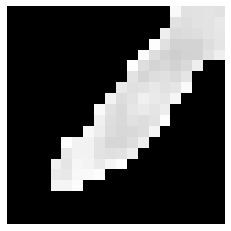

In [14]:
rec = cv2.imread(df.loc[df.index[10],"img_rec_path"],0)
my_cv.display_gray(rec)

In [15]:
class Recognizer():
    @staticmethod
    #rectangleを受け取ってlabelとconfidenceを返す
    def predict(rec):
        
        rec = rec.reshape((1,1,20,20)).astype(np.float32)
        rec /= 255
        x = Variable(np.array(rec, dtype=np.float32))
        model = CNN()
        chainer.serializers.load_npz("cnn.net",model)
        y = model.forward(x)
        label = np.argmax(y.data[0])
        confidence = abs(y.data[0][label])*100
        return label,confidence

In [16]:
Recognizer.predict(rec)

variable([[0. 1.]])


(1, 0.0)

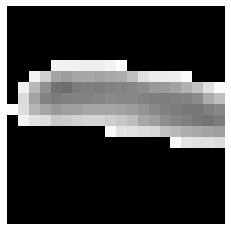

(1, 1, 20, 20)
variable([[9.9974716e-01 2.5281310e-04]])


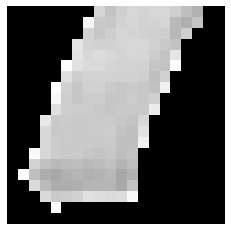

(1, 1, 20, 20)
variable([[1. 0.]])


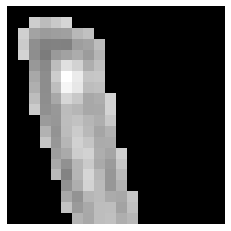

(1, 1, 20, 20)
variable([[0.0041661 0.9958339]])


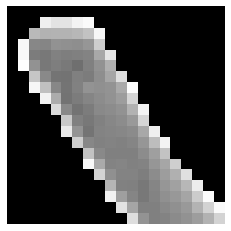

(1, 1, 20, 20)
variable([[9.999991e-01 8.940697e-07]])


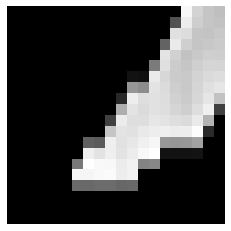

(1, 1, 20, 20)
variable([[0. 1.]])


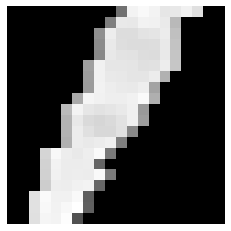

(1, 1, 20, 20)
variable([[0. 1.]])


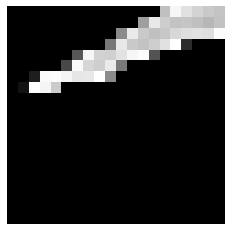

(1, 1, 20, 20)
variable([[0. 1.]])


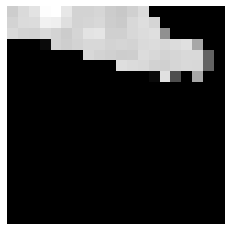

(1, 1, 20, 20)
variable([[0. 1.]])


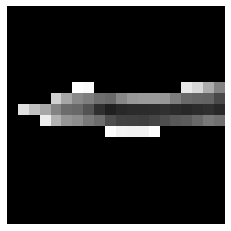

(1, 1, 20, 20)
variable([[0.04821521 0.9517848 ]])


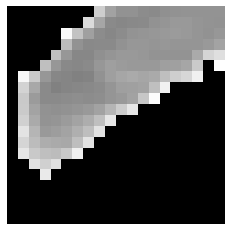

(1, 1, 20, 20)
variable([[9.9999881e-01 1.1622906e-06]])


In [24]:

for arr in X_test[0:10]:
    x = Variable(np.array([arr], dtype=np.float32))
    my_cv.display_gray(arr[0]*255)
    print(np.shape(x))
    y = model.forward(x)
    print(y)

In [ ]:
x